In [20]:
import os
import sys
import re
import uuid
import random
import imageio
import json
import numpy as np
import torch
import torch_scatter

from scipy import misc
from PIL import Image
from tqdm import tqdm
from enum import Enum

import matplotlib.pyplot as plt

# CamType = Enum("CamType", ("FirstPersonCamera", "LeftHandCamera", "RightHandCamera", "MainRoomCamera", "SecondarRoomCamera"))
CamType = Enum("CamType", ("BedroomCamera", "EntranceCamera", "FirstPersonCamera", "LeftHandCamera", "RightHandCamera"))

for name, member in CamType.__members__.items():
    print(name, '=>', member, ',', member.value)

BedroomCamera => CamType.BedroomCamera , 1
EntranceCamera => CamType.EntranceCamera , 2
FirstPersonCamera => CamType.FirstPersonCamera , 3
LeftHandCamera => CamType.LeftHandCamera , 4
RightHandCamera => CamType.RightHandCamera , 5


In [21]:
def ypr2rotmat(yaw, pitch, roll):
    yaw = np.deg2rad(yaw)
    pitch = np.deg2rad(pitch)
    roll = np.deg2rad(roll)

    CY, SY = np.cos(yaw), np.sin(yaw)
    CP, SP = np.cos(pitch), np.sin(pitch)
    CR, SR = np.cos(roll), np.sin(roll)

    M = np.eye(3)
    M[0][0] = CP * CY
    M[0][1] = CP * SY
    M[0][2] = SP

    M[1][0] = SR * SP * CY - CR * SY
    M[1][1] = SR * SP * SY + CR * CY
    M[1][2] = -SR * CP

    M[2][0] = -(CR * SP * CY + SR * SY)
    M[2][1] = CY * SR - CR * SP * SY
    M[2][2] = CR * CP

    return M.T

def RGBD2PCD(rgbs, depths, intrinsics, c2ws):
    # Assuming rgbs is of shape (N, 3, H, W), depths is of shape (N, 1, H, W), and c2ws is of shape (N, 4, 4)
    N, _, H, W = rgbs.shape
    if len(intrinsics.shape) == 2:
        intrinsics = intrinsics[None]
    intrinsics = torch.tensor(intrinsics, dtype=torch.float32, device=rgbs.device)

    with torch.no_grad():
        # Create meshgrid for x and y coordinates
        pos_x, pos_y = torch.meshgrid(torch.arange(W, device=rgbs.device), torch.arange(H, device=rgbs.device), indexing='xy')
        pos_x = pos_x.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)
        pos_y = pos_y.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)

        # Stack x and y coordinates and reshape to (N, H*W, 2)
        p_img = torch.stack([pos_x, pos_y], dim=-1).reshape(N, -1, 2)  # Shape: (N, H*W, 2)

        # Compute x_cam and y_cam
        x_cam = (p_img[:, :, 0] - intrinsics[:, 0, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 0, 0].unsqueeze(1)
        y_cam = (p_img[:, :, 1] - intrinsics[:, 1, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 1, 1].unsqueeze(1)

        # Stack x_cam, y_cam, depth, and ones to form homogeneous coordinates
        p_cam_homo = torch.stack([x_cam, y_cam, depths.reshape(N, -1), torch.ones_like(x_cam, device=rgbs.device)], dim=-1)  # Shape: (N, H*W, 4)
        p_cam_homo = p_cam_homo[:, :, [2, 0, 1, 3]]
        p_cam_homo[:, 1:3] *= -1

        # Transform to world coordinates
        p_world = torch.matmul(p_cam_homo, c2ws.transpose(-2, -1))[:, :, :3]  # Shape: (N, H*W, 3)

        # Reshape rgb to (N, H*W, 3)
        rgb_world = rgbs.permute(0, 2, 3, 1).reshape(N, -1, 3)  # Shape: (N, H*W, 3)
    
    return p_world, rgb_world

In [22]:
data_folder = "../data/robotrix/003_studioapartment/000"
cam_type = "FirstPersonCamera"
assert cam_type in CamType.__members__, f"cam_type must be one of {CamType.__members__.keys()}"
assert cam_type == CamType[cam_type].name
cam_type = CamType[cam_type]

# load the json info
with open(os.path.join(data_folder, 'studioapartment_000.json')) as f:
    data_info = json.load(f)
    n_images = len(data_info['frames'])
    print(f"Totally {n_images} images")

with open(os.path.join(data_folder, 'sceneObject.json')) as f:
    instance_info = json.load(f)
    for obj in instance_info['SceneObjects']:
        if obj['instance_name'] == cam_type.name:
            cam_color = np.array([obj['instance_color']['r'], obj['instance_color']['g'], obj['instance_color']['b']])
            print(obj['instance_color'])

Totally 3366 images
{'r': 255, 'g': 61, 'b': 190}


850
c2w: 
 [[-6.41488884e-01  7.57226920e-01 -1.22879628e-01  3.05378998e+02]
 [-7.67100168e-01 -6.31712528e-01  1.11788253e-01  8.82630005e+01]
 [ 7.02447381e-03  1.65971905e-01  9.86105463e-01  1.40313995e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(-0.5, 1919.5, 1079.5, -0.5)

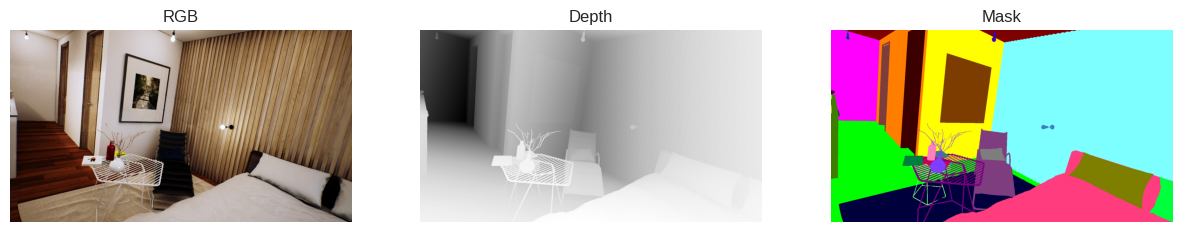

In [23]:
idx = random.randint(0, n_images)
idx = 850
print(idx)
cam_id = int(data_info['frames'][idx]['id'])
img = np.array(Image.open(os.path.join(data_folder, 'rgb', cam_type.name, f"{cam_id+1:06d}.jpg")))
depth = np.array(Image.open(os.path.join(data_folder, 'depth', cam_type.name, f"{cam_id+1:06d}.png")))
mask = np.array(Image.open(os.path.join(data_folder, 'mask', cam_type.name, f"{cam_id+1:06d}.png")))
# data_info['frames'][1]['cameras'][0]['position']
cam_position = data_info['frames'][idx]['cameras'][cam_type.value-1]['position']  # x, y, z
cam_rotation = data_info['frames'][idx]['cameras'][cam_type.value-1]['rotation']  # p, y, r
fov = float(data_info['cameras'][cam_type.value-1]['fov'])
H, W = img.shape[:2]
f = W / (2 * np.tan(np.deg2rad(fov/2)))
intrinsics = np.array([[f, 0, W/2], [0, f, H/2], [0, 0, 1]])

# transfer string to float number'
cam_position = {k: float(v) for k, v in cam_position.items()}
cam_rotation = {k: float(v) for k, v in cam_rotation.items()}

c2w = np.eye(4)
c2w[:3, :3] = ypr2rotmat(cam_rotation['y'], cam_rotation['p'], cam_rotation['r'])
c2w[:3, 3] = np.array([cam_position['x'], cam_position['y'], cam_position['z']])
print("c2w: \n", c2w)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img)
plt.title("RGB")
plt.axis("off")

plt.subplot(132)
plt.imshow(depth)
plt.title("Depth")
plt.axis("off")

plt.subplot(133)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")

Text(0.5, 1.0, 'Camera Positions')

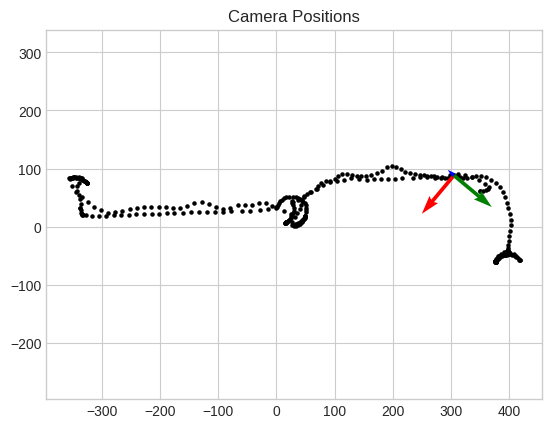

In [24]:
# draw the camera positions
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.axis("equal")
for i in range(0, n_images, 10):
# for i in range(0, n_images, 1):
    cam_position = data_info['frames'][i]['cameras'][cam_type.value-1]['position']
    cam_position = {k: float(v) for k, v in cam_position.items()}
    plt.scatter(cam_position['x'], cam_position['y'], c='black', s=5)

cam_position = data_info['frames'][idx]['cameras'][cam_type.value-1]['position']
cam_position = {k: float(v) for k, v in cam_position.items()}
cam_rotation = data_info['frames'][idx]['cameras'][cam_type.value-1]['rotation']
cam_rotation = {k: float(v) for k, v in cam_rotation.items()}
c2w = np.eye(4)
c2w[:3, :3] = ypr2rotmat(cam_rotation['y'], cam_rotation['p'], cam_rotation['r'])
c2w[:3, 3] = np.array([cam_position['x'], cam_position['y'], cam_position['z']])
# c2w[1, :] = -c2w[1, :]  # flip y axis
# c2w[:3, 1] = -c2w[:3, 1]  # flip y axis
# plot the camera orientation in x-y plane
xc = c2w[:3, 0]
yc = c2w[:3, 1]
zc = c2w[:3, 2]

plt.quiver(c2w[0, 3], c2w[1, 3], xc[0], xc[1], angles='xy', scale_units='inches', scale=2, color='r', label='x')
plt.quiver(c2w[0, 3], c2w[1, 3], yc[0], yc[1], angles='xy', scale_units='inches', scale=2, color='g', label='y')
plt.quiver(c2w[0, 3], c2w[1, 3], zc[0], zc[1], angles='xy', scale_units='inches', scale=2, color='b', label='z')

plt.title("Camera Positions")

In [28]:
imgs, depths, masks, c2ws = [], [], [], []
# for i in range(1, n_images+1, 100):
# for i in range(0, 3000, 100):
for i in range(750, 850, 50):
    cam_id = int(data_info['frames'][i]['id'])
    img = np.array(Image.open(os.path.join(data_folder, 'rgb', cam_type.name, f"{cam_id+1:06d}.jpg")))
    depth = np.array(Image.open(os.path.join(data_folder, 'depth', cam_type.name, f"{cam_id+1:06d}.png"))) / 10.0
    mask = np.array(Image.open(os.path.join(data_folder, 'mask', cam_type.name, f"{cam_id+1:06d}.png")))[..., :3]
    imgs.append(img)
    depths.append(depth)
    masks.append(mask)

    cam_position = data_info['frames'][i]['cameras'][cam_type.value-1]['position']
    cam_position = {k: float(v) for k, v in cam_position.items()}
    cam_rotation = data_info['frames'][i]['cameras'][cam_type.value-1]['rotation']
    cam_rotation = {k: float(v) for k, v in cam_rotation.items()}
    c2w = np.eye(4)
    c2w[:3, :3] = ypr2rotmat(cam_rotation['y'], cam_rotation['p'], cam_rotation['r'])
    c2w[:3, 3] = np.array([cam_position['x'], cam_position['y'], cam_position['z']])
    # c2w[1, [0, 2, 3]] = -c2w[1, [0, 2, 3]]  # flip y axis
    # regenerate y orientation though cross product
    # c2w[:3, 1] = np.cross(c2w[:3, 2], c2w[:3, 0])
    c2w[1, :] = -c2w[1, :]  # flip y axis
    c2w[:3, 1] = -c2w[:3, 1]

    # c2w[1, [0, 3]] *= -1
    c2ws.append(c2w)
    print(c2w)

rgbs = np.stack(imgs, axis=0).transpose(0, 3, 1, 2)
depths = np.stack(depths, axis=0)[:, None]
masks = np.stack(masks, axis=0)
c2ws = np.stack(c2ws, axis=0)

p_world, rgb_world = RGBD2PCD(torch.tensor(rgbs, dtype=torch.float32), torch.tensor(depths, dtype=torch.float32), intrinsics, torch.tensor(c2ws, dtype=torch.float32))
# pcd_mask = masks.reshape(-1, 3)
# pcd_mask = (pcd_mask[:, 0] == 0) & (pcd_mask[:, 1] == 0) & (pcd_mask[:, 2] == 0)
# pcd_mask = ~pcd_mask
pcd_xyz = p_world.cpu().numpy().reshape(-1, 3)[::100]
pcd_rgb = rgb_world.cpu().numpy().reshape(-1, 3)[::100]

[[-3.48952360e-01  8.41935704e-01 -4.11553789e-01  3.77164001e+02]
 [-4.22125026e-01 -5.33298022e-01 -7.33078224e-01 -7.47249985e+01]
 [-8.36685552e-01 -8.20822229e-02  5.41497734e-01  1.31483002e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-8.64546551e-01 -1.91889005e-01 -4.64475909e-01  3.36196014e+02]
 [ 2.58944492e-01 -9.62191288e-01 -8.44729232e-02 -8.55619965e+01]
 [-4.30705248e-01 -1.93304253e-01  8.81547761e-01  1.36574005e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


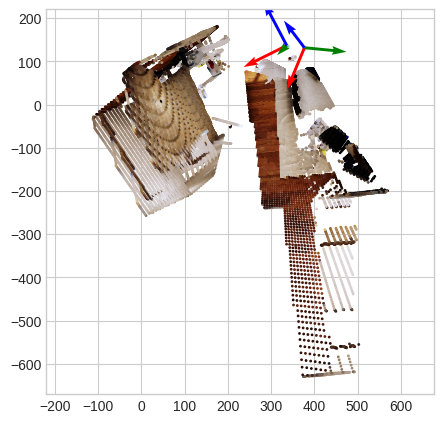

In [29]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(5, 5))
plt.axis("equal")
dim = 2
plt.scatter(pcd_xyz[:, 0], pcd_xyz[:, dim], c=pcd_rgb[:] / 255, s=1)

plt.scatter(c2ws[:, 0, 3], c2ws[:, dim, 3], s=5)
for c2w in c2ws:
    xc = c2w[:3, 0]
    yc = c2w[:3, 1]
    zc = c2w[:3, 2]

    plt.quiver(c2w[0, 3], c2w[dim, 3], xc[0], xc[dim], angles='xy', scale_units='inches', scale=2, color='r', label='x')
    plt.quiver(c2w[0, 3], c2w[dim, 3], yc[0], yc[dim], angles='xy', scale_units='inches', scale=2, color='g', label='y')
    plt.quiver(c2w[0, 3], c2w[dim, 3], zc[0], zc[dim], angles='xy', scale_units='inches', scale=2, color='b', label='z')


In [27]:
from plyfile import PlyData, PlyElement
# 确保输入数组形状正确
assert pcd_xyz.shape[0] == pcd_rgb.shape[0], "坐标和颜色数组的点数量不一致"
assert pcd_xyz.shape[1] == 3, "坐标数组应为(N, 3)"
assert pcd_rgb.shape[1] == 3, "颜色数组应为(N, 3)"

# 转换颜色到uint8（假设颜色值在0-255或0-1范围内）
if pcd_rgb.dtype != np.uint8:
    if np.max(pcd_rgb) <= 1.0:
        pcd_rgb = (pcd_rgb * 255).astype(np.uint8)
    else:
        pcd_rgb = pcd_rgb.astype(np.uint8)

# 创建结构化数组
vertex_dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
vertices = np.empty(pcd_xyz.shape[0], dtype=vertex_dtype)

# 填充数据
vertices['x'] = pcd_xyz[:, 0].astype('f4')
vertices['y'] = pcd_xyz[:, 1].astype('f4')
vertices['z'] = pcd_xyz[:, 2].astype('f4')
vertices['red'] = pcd_rgb[:, 0]
vertices['green'] = pcd_rgb[:, 1]
vertices['blue'] = pcd_rgb[:, 2]

# 生成并保存PLY文件
ply_element = PlyElement.describe(vertices, 'vertex')
PlyData([ply_element]).write('colored_point_cloud.ply')